In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List
from pandas import DataFrame
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error

from loader import df_train_origin, df_test_origin, df_geography_origin, df_product_origin, preprocess_train, preprocess_test
from models.dcf import DistributionalConditionalForecast, dcf_loss

In [2]:
df_train = df_train_origin.merge(df_geography_origin, on='Zip', how='left')
df_test = df_test_origin.merge(df_geography_origin, on='Zip', how='left')

In [3]:
regions: List = df_train['Region'].unique()

In [4]:
df_train_region: Dict[str, DataFrame] = {}
df_test_region: Dict[str, DataFrame] = {}

for region in regions:
	df_train_region[region] = df_train[df_train['Region'] == region].copy()
	df_test_region[region] = df_test[df_test['Region'] == region].copy()

In [5]:
train_loaders: Dict[str, DataLoader] = {}
val_loaders: Dict[str, DataLoader] = {}
test_loaders: Dict[str, DataLoader] = {}

for region in regions:
	train_loaders[region], val_loaders[region], scaler = preprocess_train(df_train_region[region])
	test_loaders[region] = preprocess_test(df_test_region[region], scaler)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
models: Dict[str, DistributionalConditionalForecast] = {}

for region in regions:
	models[region] = DistributionalConditionalForecast(
		window_size=30, 
		num_series=2, 
		static_dim=18,
		latent_dim=32, 
		hidden_dim=128,
		dropout=0.1, 
		output_dim=2
	)
	models[region] = models[region].to(device)

In [8]:
for region in regions:
	print(f"------------ Training {region}... ------------")
	train_loader = train_loaders[region]
	val_loader = val_loaders[region]
	model = models[region]

	optimizer = optim.Adam(model.parameters(), lr=0.001)
	scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
	kl_start = 0.0
	kl_max = 0.001

	epochs = 100
	train_losses = []
	val_losses = []
	best_val_loss = float('inf')

	for epoch in range(epochs):
		model.train()
		running_loss = 0.0
		# KL annealing
		kl_weight = min(0.001, 0.001 * (epoch / 50))  # Từ 0 -> 0.001 dần dần
		
		for x_seq, x_cal, y in train_loader:
			x_seq = x_seq.to(device)
			x_cal = x_cal.to(device)
			y = y.to(device)
			
			optimizer.zero_grad()
			out, mu_z, logvar_z = model(x_seq, x_cal)
			loss = dcf_loss(out, y, mu_z, logvar_z, kl_weight=kl_weight)
			loss.backward()
			nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
			optimizer.step()
			
			running_loss += loss.item() * x_seq.size(0)
		
		epoch_train_loss = running_loss / len(train_loader.dataset)
		train_losses.append(epoch_train_loss)
		
		model.eval()
		running_val_loss = 0.0
		with torch.no_grad():
			for x_seq, x_cal, y in val_loader:
				x_seq = x_seq.to(device)
				x_cal = x_cal.to(device)
				y = y.to(device)
				out, mu_z, logvar_z = model(x_seq, x_cal)
				loss = dcf_loss(out, y, mu_z, logvar_z, kl_weight=kl_weight)
				running_val_loss += loss.item() * x_seq.size(0)
		epoch_val_loss = running_val_loss / len(val_loader.dataset)
		val_losses.append(epoch_val_loss)
		
		scheduler.step(epoch_val_loss)
		if (epoch + 1) % 10 == 0:
			print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, "
			f"Val Loss: {epoch_val_loss:.4f}, KL Weight: {kl_weight:.6f}")
		
		if epoch_val_loss < best_val_loss:
			best_val_loss = epoch_val_loss
			checkpoint = {
				'epoch': epoch+1,
				'model_state_dict': model.state_dict(),
				'optimizer_state_dict': optimizer.state_dict(),
				'val_loss': epoch_val_loss
			}
			torch.save(checkpoint, f'checkpoints/PDCF_{region}.pth')
			print(f"Best model updated at epoch {epoch+1} with validation loss {epoch_val_loss:.4f}")

------------ Training Central... ------------
Best model updated at epoch 1 with validation loss 1.9797
Best model updated at epoch 2 with validation loss 1.7852
Best model updated at epoch 3 with validation loss 1.5883
Best model updated at epoch 4 with validation loss 1.1672
Best model updated at epoch 5 with validation loss 0.9772
Best model updated at epoch 6 with validation loss 0.8081
Best model updated at epoch 7 with validation loss 0.7150
Best model updated at epoch 8 with validation loss 0.5282
Best model updated at epoch 9 with validation loss 0.4835
Epoch [10/100], Train Loss: 0.2852, Val Loss: 0.3954, KL Weight: 0.000180
Best model updated at epoch 10 with validation loss 0.3954
Best model updated at epoch 11 with validation loss 0.3928
Best model updated at epoch 12 with validation loss 0.3366
Best model updated at epoch 13 with validation loss 0.2145
Best model updated at epoch 14 with validation loss 0.1167
Best model updated at epoch 17 with validation loss 0.1080
Best

------------ Central ------------
Test R-squared: 0.9784
Test MAPE: 0.6205
Test RMSE: 56551.9414
Test Units R-squared: 0.9738
Test Units MAPE: 0.6291
Test Units RMSE: 12.0408
Test Revenue R-squared: 0.9831
Test Revenue MAPE: 0.6120
Test Revenue RMSE: 79976.5469


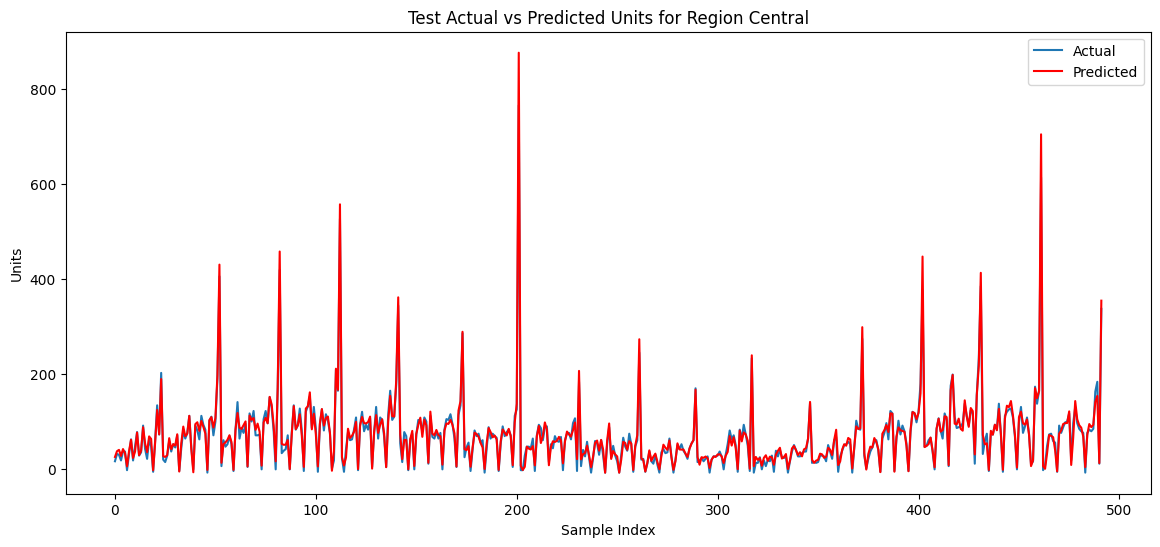

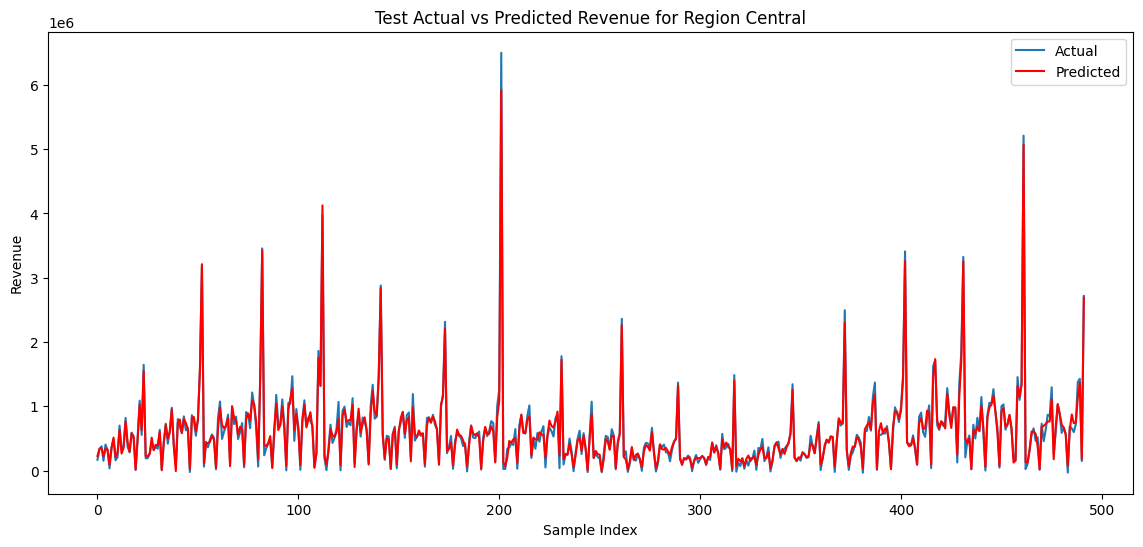

------------ West ------------
Test R-squared: 0.9762
Test MAPE: 0.6781
Test RMSE: 38681.6797
Test Units R-squared: 0.9690
Test Units MAPE: 0.3880
Test Units RMSE: 8.7377
Test Revenue R-squared: 0.9834
Test Revenue MAPE: 0.9682
Test Revenue RMSE: 54704.1523


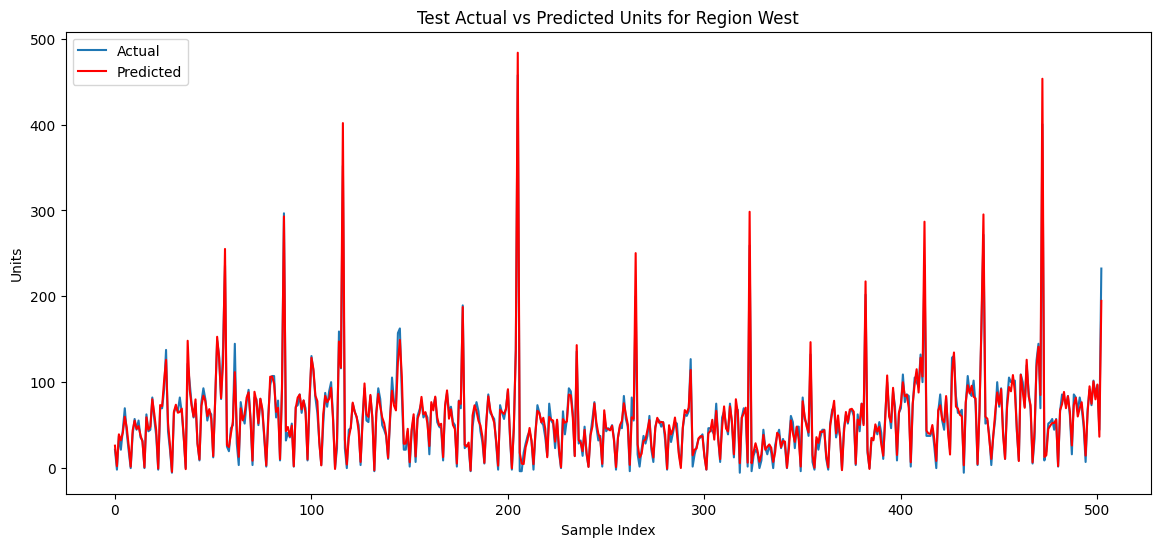

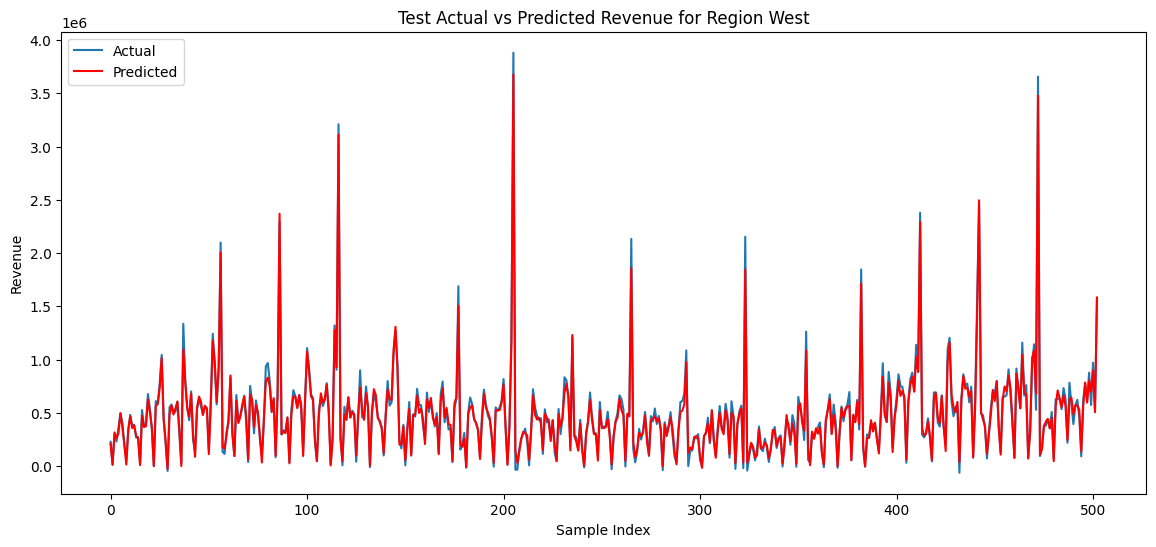

------------ East ------------
Test R-squared: 0.9814
Test MAPE: 0.1886
Test RMSE: 47860.2031
Test Units R-squared: 0.9836
Test Units MAPE: 0.2140
Test Units RMSE: 7.7574
Test Revenue R-squared: 0.9792
Test Revenue MAPE: 0.1631
Test Revenue RMSE: 67684.5469


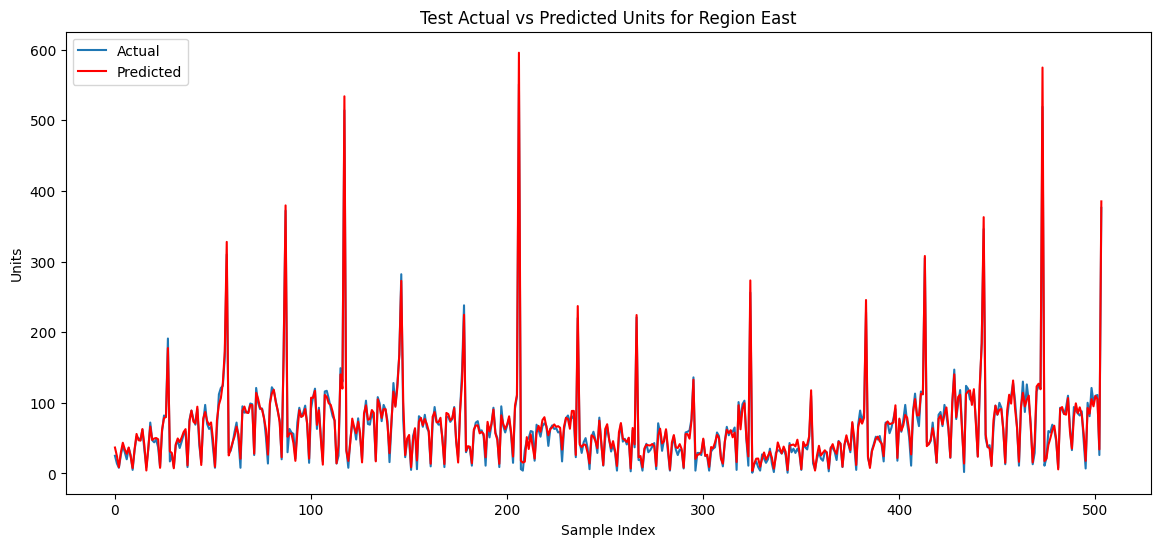

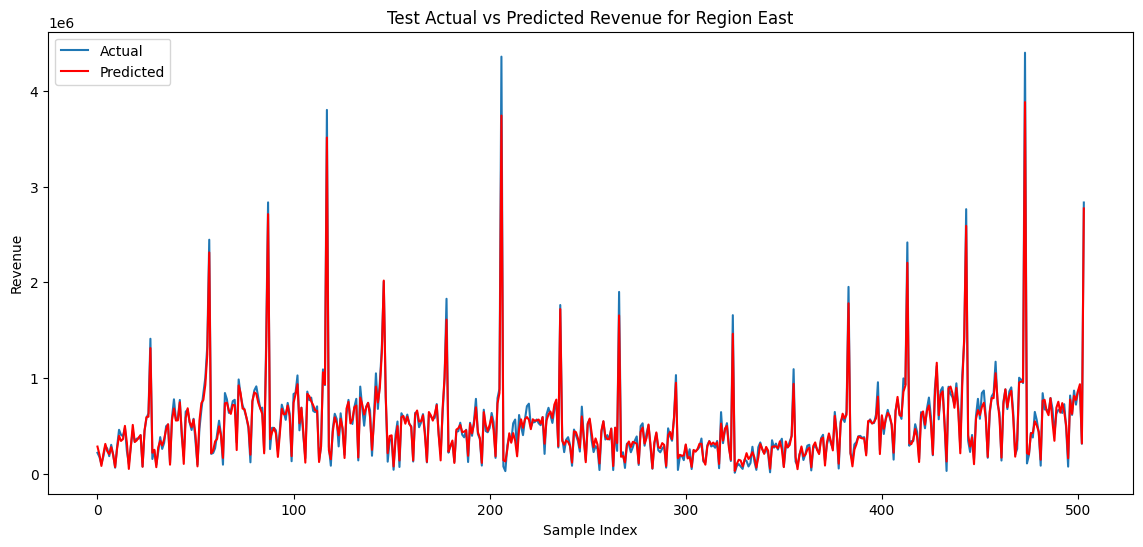

In [14]:
for region in regions:
	model = models[region]
	test_loader = test_loaders[region]
	
	model.eval()
	all_mu = []
	all_actuals = []
	with torch.no_grad():
		for x_seq, x_cal, y in test_loader:
			x_seq = x_seq.to(device)
			x_cal = x_cal.to(device)
			y = y.to(device)
			out, mu_z, logvar_z = model(x_seq, x_cal)
			output_dim = out.shape[1] // 2
			mu_y = out[:, :output_dim]         # Predicted mean (scaled)
			all_mu.append(mu_y.cpu().numpy())
			all_actuals.append(y.cpu().numpy())

	mu_preds = np.concatenate(all_mu, axis=0)         # Shape: (n_samples, output_dim)
	actuals = np.concatenate(all_actuals, axis=0)

	# Inverse transform predicted mean và actual:
	mu_preds_inv = scaler.inverse_transform(mu_preds)
	actuals_inv = scaler.inverse_transform(actuals)

	r2 = r2_score(actuals_inv, mu_preds_inv)
	mape = mean_absolute_percentage_error(actuals_inv, mu_preds_inv)
	rmse = np.sqrt(mean_squared_error(actuals_inv, mu_preds_inv))

	print(f"------------ {region} ------------")
	print(f"Test R-squared: {r2:.4f}")
	print(f"Test MAPE: {mape:.4f}")
	print(f"Test RMSE: {rmse:.4f}")

	r2_units = r2_score(actuals_inv[:, 0], mu_preds_inv[:, 0])
	mape_units = mean_absolute_percentage_error(actuals_inv[:, 0], mu_preds_inv[:, 0])
	rmse_units = np.sqrt(mean_squared_error(actuals_inv[:, 0], mu_preds_inv[:, 0]))

	print(f"Test Units R-squared: {r2_units:.4f}")
	print(f"Test Units MAPE: {mape_units:.4f}")
	print(f"Test Units RMSE: {rmse_units:.4f}")

	r2_revenue = r2_score(actuals_inv[:, 1], mu_preds_inv[:, 1])
	mape_revenue = mean_absolute_percentage_error(actuals_inv[:, 1], mu_preds_inv[:, 1])
	rmse_revenue = np.sqrt(mean_squared_error(actuals_inv[:, 1], mu_preds_inv[:, 1]))

	print(f"Test Revenue R-squared: {r2_revenue:.4f}")
	print(f"Test Revenue MAPE: {mape_revenue:.4f}")
	print(f"Test Revenue RMSE: {rmse_revenue:.4f}")

	x_axis = np.arange(len(actuals_inv))

	plt.figure(figsize=(14, 6))
	plt.plot(actuals_inv[:, 0], label='Actual')
	plt.plot(mu_preds_inv[:, 0], label='Predicted', color='red')
	plt.title('Test Actual vs Predicted Units for Region ' + region)
	plt.xlabel('Sample Index')
	plt.ylabel('Units')
	plt.legend()
	plt.show()

	plt.figure(figsize=(14, 6))
	plt.plot(actuals_inv[:, 1], label='Actual')
	plt.plot(mu_preds_inv[:, 1], label='Predicted', color='red')
	plt.title('Test Actual vs Predicted Revenue for Region ' + region)
	plt.xlabel('Sample Index')
	plt.ylabel('Revenue')
	plt.legend()
	plt.show()